# ResNet34 image model

Here we abide by resnets preprocessing which is simply rgb channel images. The images dont require pixel scalling due the batchnormalization layers within dense net.

This model was implemented using pytorch due to its simple image augmentation and loading aswell as its inclusion of a pretrained 34 residual layer model. 

In [1]:
import os
import random
import pandas as pd
import numpy as np
from copy import copy
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.models as models
from torchvision.utils import make_grid

import warnings
warnings.simplefilter('ignore')

# Helper functions

In [2]:
def accuracy(outputs, labels):
    '''
    modeling accuracy function
    '''
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [11]:
def to_device(data, device):
    '''
    move tensors to chosen device
    '''
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking = True)

class DeviceDataLoader():
    '''
    move data from dataloader to device
    '''
    def __init__(self, data_loader, device):
        self.data_loader = data_loader
        self.device = device
        
    def __iter__(self):
        for batch in self.data_loader: 
            yield to_device(batch, self.device)

    def __len__(self):
        return len(self.data_loader)

# Dataloading + Augmentation

In [3]:
#file locations
data_loc = '/content/drive/MyDrive/kaggle/smallsign' 
classes = os.listdir(data_loc + '/asl_alphabet_train/asl_alphabet_train')

In [4]:
#creating pytorch image transformers
train_aug = transforms.Compose([
                        transforms.RandomCrop(200, padding=25, padding_mode='reflect'),
                        transforms.RandomHorizontalFlip(),
                        transforms.RandomRotation(15),
                        transforms.RandomPerspective(distortion_scale=0.2),
                        transforms.ToTensor()
                        #color transforms performed worse(colorjitter etc)
                        ])

#images are 200x200 so just need to convert to tensor for use with pytorch
test_aug = transforms.Compose([transforms.ToTensor()])

In [5]:
image locations
data = ImageFolder(data_loc + '/asl_alphabet_train/asl_alphabet_train', transform=train_aug)

In [6]:
#train-test split
val_len = int(0.2 * len(data))
train_len = len(data) - val_len

train, val = random_split(data, [train_len, val_len])
print(f'Training files: {len(train)}')
print(f'Validation files: {len(val)}')

Training files: 69600
Validation files: 17400


In [7]:
#apply transformers
train.dataset = copy(data)
train.dataset.transform = train_aug
val.dataset.transform = test_aug

In [8]:
loading_batch = 64

loaded_train = DataLoader(
                        train, 
                        loading_batch, 
                        shuffle = True, 
                        num_workers = 4, 
                        pin_memory = True
                )

loaded_val = DataLoader(
                    val, 
                    loading_batch*2, 
                    num_workers = 4, 
                    pin_memory = True
                )

# Image plots

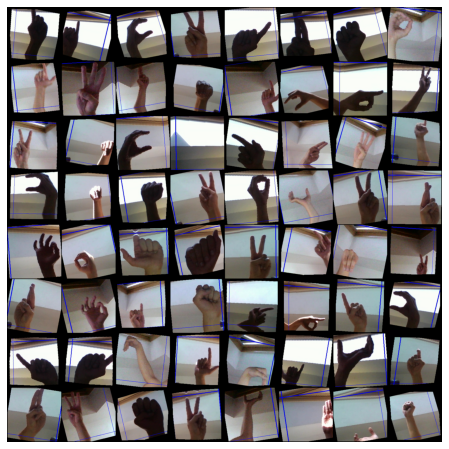

In [9]:
# plot of augmented train images
for images, _ in loaded_train:
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images.cpu(), nrow=8).permute((1, 2, 0)))
    break

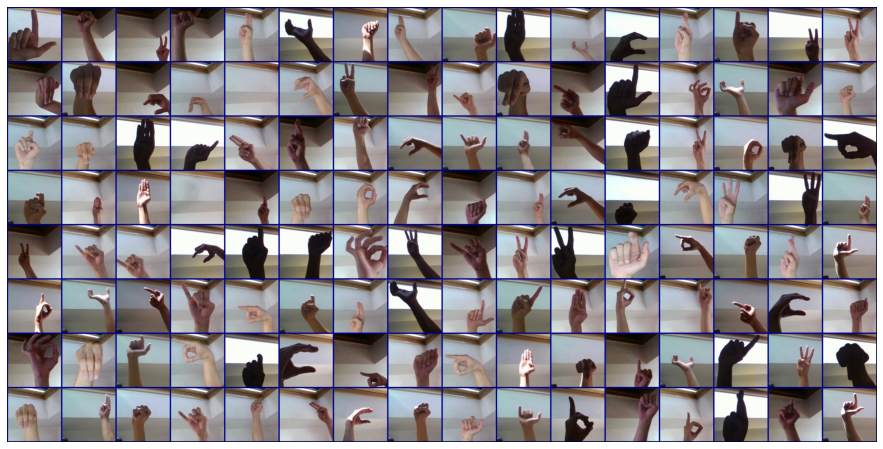

In [10]:
# plot "augmented" val images
for images, _ in loaded_val:
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images.cpu(), nrow=16).permute((1, 2, 0)))
    break

# Modeling

In [12]:
class base_model(nn.Module):

    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print(f'Epoch [{epoch}]: \
            val_loss: {result["val_loss"]:.4f}, \
            val_acc: {result["val_acc"]:.4f}')

In [13]:
class Resnet(base_model):

    def __init__(self):
        '''
        load pretrained resnet model
        '''
        super().__init__()
        self.network = models.resnet34(pretrained=True)
        num_features = self.network.fc.in_features
        self.network.fc = nn.Linear(num_features, 29)
    
    def forward(self, xb):
        return self.network(xb)
    
    def freeze(self):
        '''
        freezes all non fully conected layers
        '''
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        '''
        unfreezes all layers
        '''
        for param in self.network.parameters():
            param.require_grad = True

In [14]:
@torch.no_grad()
def evaluate(model, val_loader):
    '''
    puts model in evaluation mode to evaluation mode to check performance
    eval mode doesnt compute gradients or include layers such as dropout
    '''
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    '''
    get learning rate from optimizer
    '''
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_epochs(epochs, 
               max_lr, 
               model, 
               train_loader,
               val_loader,
               optim_function,
               weight_decay = 0, 
               grad_clip = None):
    '''
    function to train the model
    params:
    epochs (int): epochs to train for
    max_lr (float): maximum learning rate for optimizer while training
    model (pytorch object): the model to train
    train_loader (pytorch object): pytorch data loader for training
    val_loader (pytorch object): pytorch data loader for validation
    weight_decay (float): value for weight decay scaling for optimizer
    grad_clip (float): value for gradient clipping
    optim_function (pytorch object): which torch optimizer ytou wish to use
    '''
    torch.cuda.empty_cache()
    history = []
    
    optimizer = optim_function(
                    model.parameters(), 
                    max_lr, 
                    weight_decay=weight_decay
                )
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
                                            optimizer, 
                                            max_lr, 
                                            epochs=epochs, 
                                            steps_per_epoch=len(train_loader)
                                        )
    
    for epoch in range(epochs):

        model.train()
        train_losses = []
        learning_rates = []

        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            learning_rates.append(get_lr(optimizer))
            scheduler.step()
        
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['learning_rates'] = learning_rates
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [15]:
device = torch.device('cuda')
device

device(type='cuda')

In [16]:
loaded_train = DeviceDataLoader(loaded_train, device)
loaded_val = DeviceDataLoader(loaded_val, device)

In [17]:
model = to_device(Resnet(), device)

In [18]:
train_hist = [evaluate(model, loaded_val)]
train_hist

[{'val_acc': 0.02437959611415863, 'val_loss': 3.5420172214508057}]

In [19]:
#partially train new fully connected layers with lower layers frozen
model.freeze()
optimizer = torch.optim.Adam

train_hist += fit_epochs(1, 1e-4, model, loaded_train, loaded_val, 
                      optimizer, weight_decay = 1e-4,
                      grad_clip = 0.15)

Epoch [0]:             val_loss: 0.0031,             val_acc: 0.9999


In [20]:
#fine tune the whole model with lower learning rate
model.unfreeze()
train_hist += fit_epochs(1, 1e-5, model, loaded_train, loaded_val, 
                      optimizer, weight_decay = 1e-4,
                      grad_clip = 0.15)

Epoch [0]:             val_loss: 0.0016,             val_acc: 0.9999


The rate at which this model converges is very quick and it predicts very well on live images. The main drawback is that ResNet isnt as lightweight as MobileNetV2 meaning slower rate of prediction. However, the boost in recognition accuracy with resnet drastically outperforms the mobilenet version.

# Model Evaluation

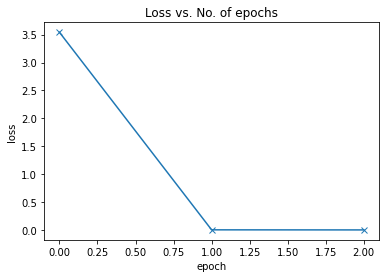

In [21]:
#plot of val losses
losses = [x['val_loss'] for x in train_hist]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

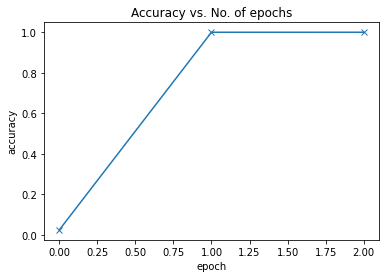

In [22]:
#plot of val acc
accs = [x['val_acc'] for x in train_hist]
plt.plot(accs, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

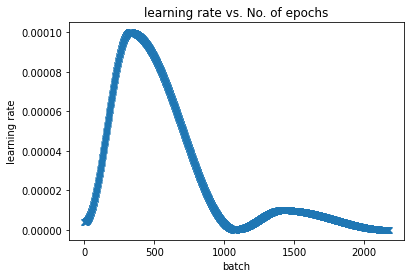

In [23]:
#plot of lr
lr = np.concatenate([x.get('learning_rates', []) for x in train_hist])
plt.plot(lr, '-x')
plt.xlabel('batch')
plt.ylabel('learning rate')
plt.title('learning rate vs. No. of epochs');

In [24]:
torch.save(model.state_dict(), '/content/asl-model_GC.pth')